<a href="https://colab.research.google.com/github/luisagoncalves/analise-dados-icd/blob/main/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto Final de Introdução à Ciência de Dados**

### **Estudantes**
Danielle Ester Barbosa da Silva e Luísa Oliveira Gonçalves

### **Base SRAG escolhida**
Base de dados da Síndrome Respiratória Aguda Grave (SRAG), no período de 2019 a 2025.

### **Subproblema**
Diferenças regionais.

### **Objetivo**
Desenvolver uma análise exploratória e um modelo de aprendizado de máquina para compreensão dos aspectos associados às diferenças regionais de pacientes diagnosticados com COVID-19 no Brasil.

### **Coleta dos dados**
Banco de dados da Síndrome Respiratória Aguda Grave (SRAG) - 2019 a 2025
Endereço: https://opendatasus.saude.gov.br/dataset/srag-2021-a-2024
Arquivos coletados estão disponíveis no diretório ./data



In [ ]:
# Libs standards
import os
import re
import warnings
import logging
from pathlib import Path
from datetime import datetime

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Machine learning - preprocessamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine learning - modelagem e pipelines
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Machine learning - métricas
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Configuração de logs e warnings
os.environ["JOBLIB_MULTIPROCESSING"] = "0"
logging.getLogger("joblib").setLevel(logging.ERROR)
logging.getLogger("loky").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")


### **Seleção das Variáveis**

As variáveis foram selecionadas mediante análise do dicionário de dados do SIVEP-Gripe, adotando critérios que se alinham ao subproblema de investigação — especificamente, a identificação de diferenças regionais nos desfechos clínicos da COVID-19.

In [ ]:
VARIAVEIS = {
    # Variáveis principais
    'SG_UF': 'VARCHAR2(2)',                 # UF de residência - página 6
    'CLASSI_FIN': 'VARCHAR2(1)',            # Classificação final do caso - página 24
    'EVOLUCAO': 'VARCHAR2(1)',              # Evolução do caso - página 24
    'HOSPITAL': 'VARCHAR2(1)',              # Houve internação - página 15
    'UTI': 'VARCHAR2(1)',                   # Internado em UTI - página 16

    # 1. Dados demográficos
    'NU_IDADE_N': 'VARCHAR2(3)',            # Idade - página 4
    'TP_IDADE': 'VARCHAR2(1)',              # Tipo/Idade (Dia/Mês/Ano) - página 4
    'DT_NASC': 'DATE',                      # Data de nascimento - página 4

    # 2. Comorbidades
    'DIABETES': 'VARCHAR2(1)',              # Diabetes mellitus - página 9
    'CARDIOPATI': 'VARCHAR2(1)',            # Doença Cardiovascular Crônica - página 9
    'OBESIDADE': 'VARCHAR2(1)',             # Obesidade - página 10
    'RENAL': 'VARCHAR2(1)',                 # Doença Renal Crônica - página 10
    'PNEUMOPATI': 'VARCHAR2(1)',            # Outra Pneumopatia Crônica - página 9
    'ASMA': 'VARCHAR2(1)',                  # Asma - página 9
    'NEUROLOGIC': 'VARCHAR2(1)',            # Doença Neurológica Crônica - página 9
    'HEPATICA': 'VARCHAR2(1)',              # Doença Hepática Crônica - página 9
    'HEMATOLOGI': 'VARCHAR2(1)',            # Doença Hematológica Crônica - página 9
    'IMUNODEPRE': 'VARCHAR2(1)',            # Imunodeficiência - página 10

    # 3. Datas de sintomas e internação
    'DT_SIN_PRI': 'DATE',                   # Data de 1ºs sintomas - página 2
    'DT_INTERNA': 'DATE',                   # Data da internação por SRAG - página 16
    'DT_ENTUTI': 'DATE',                    # Data da entrada na UTI - página 16
}


DOMINIOS = {
    # Variáveis principais
    'SG_UF': {
        'tipo': 'VARCHAR2(2)',
        'descricao': 'Unidade Federativa de residência do paciente',
        'categorias': 'Siglas das UF padronizadas pelo IBGE (AC, AL, AM, AP, BA, CE, DF, ES, GO, MA, MG, MS, MT, PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO)',
        'obrigatorio': 'Sim (se país for Brasil)',
    },

    'CLASSI_FIN': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Classificação final do caso (diagnóstico final)',
        'categorias': {
            '1': 'SRAG por influenza',
            '2': 'SRAG por outro vírus respiratório',
            '3': 'SRAG por outro agente etiológico',
            '4': 'SRAG não especificado',
            '5': 'SRAG por covid-19'
        },
        'obrigatorio': 'Sim',
    },

    'EVOLUCAO': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Evolução do caso',
        'categorias': {
            '1': 'Cura',
            '2': 'Óbito',
            '3': 'Óbito por outras causas',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'HOSPITAL': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Houve internação?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'UTI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Internado em UTI?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    # 1. Dados demográficos
    'NU_IDADE_N': {
        'tipo': 'VARCHAR2(3)',
        'descricao': 'Idade informada pelo paciente ou idade aparente',
        'categorias': 'Valor numérico (idade <= 150)',
        'obrigatorio': 'Sim',
        'observacao': 'Calculado automaticamente se digitada a data de nascimento',
    },

    'TP_IDADE': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Tipo de unidade da idade',
        'categorias': {
            '1': 'Dia (0 a 30 dias)',
            '2': 'Mês (1 a 11 meses)',
            '3': 'Ano (>= 12 meses)'
        },
        'obrigatorio': 'Sim',
        'observacao': 'Calculado automaticamente baseado no intervalo entre data de nascimento e data dos primeiros sintomas',
    },

    'DT_NASC': {
        'tipo': 'DATE',
        'descricao': 'Data de nascimento do paciente',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Essencial',
        'validacao': 'Data deve ser <= data dos primeiros sintomas',
        'pagina': 4
    },

    # 2. Comorbidades (Fatores de risco)
    'DIABETES': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Diabetes mellitus?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'CARDIOPATI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Cardiovascular Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'OBESIDADE': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui obesidade?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },
    'RENAL': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Renal Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'PNEUMOPATI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui outra pneumopatia crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'ASMA': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Asma?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'NEUROLOGIC': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Neurológica Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'HEPATICA': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Hepática Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'HEMATOLOGI': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Doença Hematológica Crônica?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
    },

    'IMUNODEPRE': {
        'tipo': 'VARCHAR2(1)',
        'descricao': 'Paciente possui Imunodeficiência ou Imunodepressão?',
        'categorias': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'obrigatorio': 'Essencial',
        'observacao': 'Diminuição da função do sistema imunológico',
    },

    # 3. Datas de sintomas e internação
    'DT_SIN_PRI': {
        'tipo': 'DATE',
        'descricao': 'Data de 1º sintomas do caso',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Sim',
        'validacao': 'Data deve ser <= data da digitação e <= data do preenchimento da ficha',
    },

    'DT_INTERNA': {
        'tipo': 'DATE',
        'descricao': 'Data em que o paciente foi hospitalizado',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Sim',
        'validacao': 'Data deve ser >= data de 1ºs sintomas e <= data da digitação',
    },

    'DT_ENTUTI': {
        'tipo': 'DATE',
        'descricao': 'Data de entrada do paciente na Unidade de Terapia Intensiva (UTI)',
        'categorias': 'Formato DD/MM/AAAA',
        'obrigatorio': 'Essencial',
        'habilitado_se': 'Campo 53 - Internado em UTI = 1 (Sim)',
        'validacao': 'Data deve ser >= data de 1ºs sintomas e <= data da digitação',
    }
}

### **Carregamento dos dados**

# Explicação do Carregamento de Dados

## Visão Geral

Este código baixa e consolida automaticamente múltiplos arquivos CSV do SIVEP-Gripe que estão armazenados no Google Drive, combinando-os em um único DataFrame para análise.

---

## Etapa 1: Download Automático

```python
url = 'https://drive.google.com/drive/folders/...'
gdown.download_folder(url, output='data', quiet=True, use_cookies=False)
```

Baixa toda a pasta compartilhada do Google Drive e salva os arquivos localmente na pasta `data/`. O parâmetro `quiet=True` suprime mensagens de progresso para manter a saída limpa.

---

## Etapa 2: Função `carregar_dados()`

Esta função faz três coisas principais:

### 1. **Localiza os arquivos**
Busca todos os arquivos que começam com "INFLUD" e terminam com ".csv" na pasta `data/`. Esses são os arquivos oficiais do banco SIVEP-Gripe, geralmente organizados por ano ou período.

### 2. **Carrega cada arquivo com configurações especiais**
- **sep=';'**: Os arquivos usam ponto-e-vírgula como separador (padrão brasileiro)
- **dtype=str**: Lê tudo como texto inicialmente para evitar problemas de formatação
- **encoding='latin1'**: Codificação necessária para caracteres especiais em português (acentos, cedilha)
- **low_memory=False**: Garante leitura consistente de arquivos grandes
- **on_bad_lines='skip'**: Pula linhas malformadas em vez de interromper o processo

### 3. **Consolida tudo em um único DataFrame**
Para cada arquivo encontrado:
- Carrega os dados
- Seleciona apenas as colunas definidas em `VARIAVEIS` (as que são relevantes para análise)
- Exibe quantos registros foram carregados
- Adiciona à lista para consolidação

No final, combina todos os DataFrames em um só usando `pd.concat()`, ignorando os índices originais para criar uma numeração contínua.


In [ ]:
import gdown
from pathlib import Path
import pandas as pd

# Baixar pasta inteira
url = 'https://drive.google.com/drive/folders/16b4Gf37O3UP688kO0tBjK2KzztgFQkRM?usp=sharing'
gdown.download_folder(url, output='data', quiet=True, use_cookies=False)

def carregar_dados():
    """Carrega e consolida arquivos CSV do SIVEP-Gripe"""

    arquivos = sorted(Path('data').glob('INFLUD*.csv'))

    if not arquivos:
        print("Nenhum arquivo INFLUD*.csv encontrado na pasta 'data'")
        return None

    # Configuração de leitura
    config = {
        'sep': ';',
        'dtype': str,
        'encoding': 'latin1',
        'low_memory': False,
        'on_bad_lines': 'skip'
    }

    # Carrega e concatena todos os arquivos
    dfs = []
    for arquivo in arquivos:
        df = pd.read_csv(arquivo, **config)
        # Seleciona apenas variáveis que existem
        colunas = [v for v in VARIAVEIS if v in df.columns]
        dfs.append(df[colunas])
        print(f"✓ {arquivo.name}: {len(df):,} registros")

    df_final = pd.concat(dfs, ignore_index=True)

    # Resumo
    print(f"\nTotal: {len(df_final):,} registros | {len(df_final.columns)}/{len(VARIAVEIS)} variáveis selecionadas")

    return df_final


if __name__ == "__main__":
    df = carregar_dados()

✓ INFLUD19-26-06-2025.csv: 48,961 registros
✓ INFLUD20-26-06-2025.csv: 1,206,920 registros
✓ INFLUD21-26-06-2025.csv: 1,745,672 registros
✓ INFLUD22-26-06-2025.csv: 560,577 registros
✓ INFLUD23-26-06-2025.csv: 279,453 registros
✓ INFLUD24-26-06-2025.csv: 267,984 registros
✓ INFLUD25-01-12-2025.csv: 309,502 registros

Total: 4,419,069 registros | 21/21 variáveis selecionadas


### **Limpeza dos dados**

## Visão Geral

A classe `LimpezaSRAG` é responsável por transformar dados brutos do sistema SIVEP-Gripe em dados limpos e prontos para análise. Ela funciona como uma "linha de produção" que passa os dados por várias etapas de validação e padronização, garantindo qualidade e consistência.

---

## Método Principal

### `limpar_dados()`

Este é o método que você chama para executar todo o processo de limpeza. Ele organiza e executa seis etapas na sequência correta, retornando ao final um DataFrame completamente limpo e validado.

---

## Etapas de Limpeza (Métodos Internos)

### 1. `_padronizar()`

Uniformiza a forma como os dados estão escritos. Remove espaços em branco extras, converte siglas de estados para maiúsculas (ex: "sp" vira "SP"), e padroniza diferentes formas de representar valores ausentes (como "NA", "null", espaços vazios) para um formato único.

### 2. `_converter_tipos()`

Transforma a idade, que pode estar armazenada como texto, em formato numérico para permitir cálculos. Se algum valor não puder ser convertido (como "abc"), ele é marcado como ausente.

### 3. `_filtrar_dominios()`

Remove registros que não fazem sentido para a análise: casos sem desfecho conhecido (nem cura nem óbito), estados com siglas inválidas, e idades biologicamente impossíveis (menores que zero ou maiores que 120 anos).

### 4. `_tratar_ignorados()`

No banco de dados do SIVEP, o código "9" significa "informação ignorada/não preenchida". Esta etapa converte todos esses códigos em valores ausentes para facilitar o tratamento posterior.

### 5. `_remover_invalidos()`

Garante que as variáveis binárias (sim/não) só contenham os códigos válidos "1" ou "2". Remove qualquer registro com valores estranhos ou corrompidos nessas colunas.

### 6. `_remover_nulos()`

Remove todos os registros que ainda têm informações faltando nas colunas essenciais para a análise. Este é o passo final que garante que apenas dados completos serão usados nos modelos.

In [ ]:
class LimpezaSRAG:
    """
    Classe responsável pela padronização, validação e limpeza
    dos dados de SRAG para análise e modelagem.
    """

    def __init__(self, df):
        # Cria cópia do DataFrame original
        self.df = df.copy()

        # Comorbidades consideradas no estudo
        self.comorbidades = [
            'DIABETES', 'CARDIOPATI', 'OBESIDADE', 'RENAL',
            'PNEUMOPATI', 'NEUROLOGIC', 'IMUNODEPRE'
        ]

        # Unidades federativas válidas
        self.ufs_validas = [
            'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO',
            'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR',
            'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO'
        ]

        # Colunas essenciais para análise e modelagem
        self.colunas_modelo = [
            'EVOLUCAO', 'NU_IDADE_N', 'HOSPITAL', 'UTI',
            'SG_UF'
        ] + self.comorbidades

    def limpar_dados(self):
        """
        Executa a sequência completa de limpeza dos dados.
        """
        self._padronizar()
        self._converter_tipos()
        self._filtrar_dominios()
        self._tratar_ignorados()
        self._remover_invalidos()
        self._remover_nulos()

        return self.df

    def _padronizar(self):
        # Padroniza valores ausentes para NaN
        self.df.replace(
            ['', ' ', 'NA', 'N/A', 'null', 'NULL', 'None', '-', 'nan'],
            np.nan,
            inplace=True
        )

        # Normaliza códigos de UF
        if 'SG_UF' in self.df.columns:
            self.df['SG_UF'] = (
                self.df['SG_UF']
                .astype(str)
                .str.strip()
                .str.upper()
            )

        # Remove sufixos e espaços de colunas relevantes
        for col in self.colunas_modelo:
            if col in self.df.columns:
                self.df[col] = (
                    self.df[col]
                    .astype(str)
                    .str.replace('.0', '', regex=False)
                    .str.strip()
                )

    def _converter_tipos(self):
        # Converte idade para tipo numérico
        if 'NU_IDADE_N' in self.df.columns:
            self.df['NU_IDADE_N'] = pd.to_numeric(
                self.df['NU_IDADE_N'], errors='coerce'
            )

    def _filtrar_dominios(self):
        # Mantém apenas evolução conhecida (cura ou óbito)
        self.df = self.df[
            self.df['EVOLUCAO'].isin(['1', '2'])
        ]

        # Remove registros com UF inválida
        self.df = self.df[
            self.df['SG_UF'].isin(self.ufs_validas)
        ]

        # Filtra idades fora do intervalo plausível
        self.df = self.df[
            (self.df['NU_IDADE_N'] >= 0) &
            (self.df['NU_IDADE_N'] <= 120)
        ]

    def _tratar_ignorados(self):
        # Converte códigos "ignorado" em valores ausentes
        campos_ignorado = ['HOSPITAL', 'UTI'] + self.comorbidades

        for col in campos_ignorado:
            if col in self.df.columns:
                self.df.loc[self.df[col] == '9', col] = np.nan

    def _remover_invalidos(self):
        # Mantém apenas códigos válidos para hospitalização e UTI
        for col in ['HOSPITAL', 'UTI']:
            if col in self.df.columns:
                self.df = self.df[self.df[col].isin(['1', '2'])]

        # Mantém apenas códigos válidos para comorbidades
        for col in self.comorbidades:
            if col in self.df.columns:
                self.df = self.df[self.df[col].isin(['1', '2'])]

    def _remover_nulos(self):
        # Remove registros com valores ausentes nas colunas essenciais
        self.df = self.df[self.colunas_modelo].dropna()


# Execução principal
if __name__ == "__main__":
    limpeza = LimpezaSRAG(df)
    df_limpo = limpeza.limpar_dados()


### **Visualização dos dados**

## `preparar_dados_para_graficos(df_limpo)`

Esta função filtra e organiza os dados especificamente para criar gráficos regionais. Ela agrupa os estados brasileiros em cinco grandes regiões (Norte, Nordeste, Centro-Oeste, Sudeste e Sul) e identifica pacientes que têm pelo menos uma comorbidade (como diabetes, obesidade, doenças cardíacas, renais, pulmonares, neurológicas ou imunodepressão). No final, retorna apenas os dados desses pacientes mais críticos, que são o foco da análise visual.

## `gerar_graficos_painel(df_critico)`

Esta função cria um painel visual completo com gráficos que comparam as cinco regiões do Brasil. Para cada região, ela calcula: o percentual de curas e óbitos, estatísticas sobre a idade dos pacientes (média, mediana e quartis), e a prevalência de cada comorbidade. O destaque é um mapa de calor (heatmap) que mostra as cinco comorbidades mais comuns em cada região, usando cores para facilitar a comparação - quanto mais vermelho, maior a prevalência. O resultado é salvo como uma imagem.

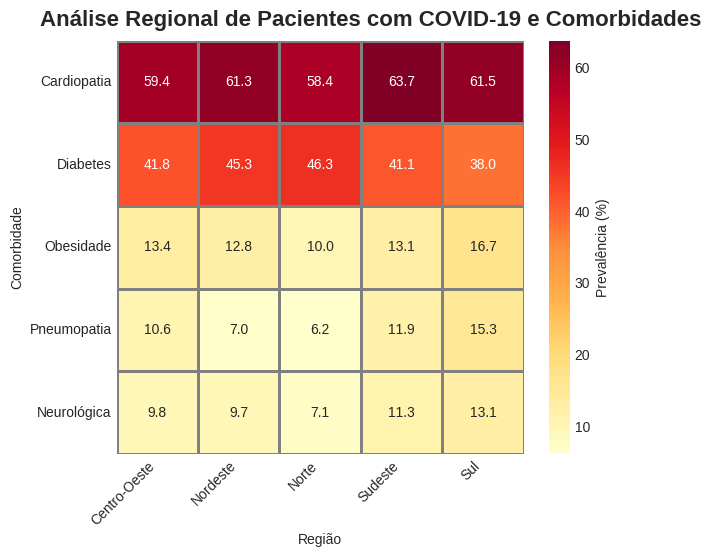

In [ ]:
def preparar_dados_para_graficos(df_limpo):
    # Mapeia UF para grandes regiões do Brasil
    mapa_regioes = {
        'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte',
        'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste',
        'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste',
        'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste',
        'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }

    # Cria cópia para preservar o DataFrame original
    df = df_limpo.copy()

    # Cria variável de região e remove registros sem correspondência
    df['REGIAO'] = df['SG_UF'].map(mapa_regioes)
    df = df[df['REGIAO'].notna()]

    # Lista de comorbidades analisadas
    comorb_cols = [
        "DIABETES", "CARDIOPATI", "OBESIDADE",
        "RENAL", "PNEUMOPATI", "NEUROLOGIC", "IMUNODEPRE"
    ]

    # Identifica pacientes com pelo menos uma comorbidade
    df['HAS_COMORB'] = (df[comorb_cols] == '1').any(axis=1)

    # Filtra apenas pacientes com comorbidades
    df_critico = df[df['HAS_COMORB']].copy()

    return df_critico


def gerar_graficos_painel(df_critico):
    # Define estilo visual dos gráficos
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    # Regiões presentes no conjunto de dados
    regioes = sorted(df_critico['REGIAO'].unique())

    # Estruturas para armazenar estatísticas regionais
    obito_pct, cura_pct = [], []
    idade_media, idade_p25, idade_p75, idade_mediana = [], [], [], []

    # Lista de comorbidades analisadas
    comorb_cols = [
        "DIABETES", "CARDIOPATI", "OBESIDADE",
        "RENAL", "PNEUMOPATI", "NEUROLOGIC", "IMUNODEPRE"
    ]

    # Dicionário para armazenar prevalência de comorbidades por região
    comorbidades = {c: [] for c in comorb_cols}

    # Calcula métricas para cada região
    for regiao in regioes:
        grupo = df_critico[df_critico['REGIAO'] == regiao]

        # Percentual de cura e óbito
        evol = grupo['EVOLUCAO'].value_counts(normalize=True) * 100
        cura_pct.append(evol.get('1', 0))
        obito_pct.append(evol.get('2', 0))

        # Estatísticas descritivas da idade
        idade = grupo['NU_IDADE_N']
        idade_media.append(idade.mean())
        idade_mediana.append(idade.median())
        idade_p25.append(idade.quantile(0.25))
        idade_p75.append(idade.quantile(0.75))

        # Prevalência de cada comorbidade
        for c in comorb_cols:
            comorbidades[c].append((grupo[c] == '1').mean() * 100)

    # Média geral de prevalência das comorbidades
    comorb_medias = {c: np.mean(v) for c, v in comorbidades.items()}

    # Seleciona as cinco comorbidades mais frequentes
    top_5 = sorted(comorb_medias.items(), key=lambda x: x[1], reverse=True)[:5]
    top_5_cols = [c for c, _ in top_5]

    # Nomes amigáveis para exibição nos gráficos
    nome_amigavel = {
        'CARDIOPATI': 'Cardiopatia',
        'DIABETES': 'Diabetes',
        'OBESIDADE': 'Obesidade',
        'RENAL': 'Doença Renal',
        'PNEUMOPATI': 'Pneumopatia',
        'NEUROLOGIC': 'Neurológica',
        'IMUNODEPRE': 'Imunodepressão'
    }

    # DataFrame para o heatmap de prevalência
    df_comorb = pd.DataFrame(
        {nome_amigavel[c]: comorbidades[c] for c in top_5_cols},
        index=regioes
    )

    # Criação da figura principal
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle(
        'Análise Regional de Pacientes com COVID-19 e Comorbidades',
        fontsize=16, fontweight='bold'
    )

    # Heatmap de prevalência das principais comorbidades por região
    ax = plt.subplot(2, 3, 2)
    sns.heatmap(
        df_comorb.T,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        linewidths=1,
        linecolor='gray',
        cbar_kws={'label': 'Prevalência (%)'},
        ax=ax
    )

    ax.set_xlabel('Região')
    ax.set_ylabel('Comorbidade')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Ajusta layout e salva a figura
    plt.tight_layout()
    plt.savefig(
        'analise_regional_covid_grave.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

    return fig


# Execução principal
if __name__ == "__main__":
    df_critico = preparar_dados_para_graficos(df_limpo)
    fig = gerar_graficos_painel(df_critico)


### **Modelagem**

## `preparar_dados(df)`

Esta função limpa e organiza os dados do SIVEP-Gripe para análise. Ela filtra apenas os casos com desfecho conhecido (cura ou óbito), converte a idade para números, agrupa os estados por região do Brasil, e seleciona as variáveis mais importantes como condições de saúde (diabetes, obesidade, doenças cardíacas etc.), informações demográficas e se o paciente foi internado ou precisou de UTI. No final, remove qualquer registro incompleto para garantir qualidade na análise.

## `calcular_auc_roc(df)`

Esta função cria e avalia um modelo de machine learning para prever óbitos. Ela divide os dados em treino (70%) e teste (30%), padroniza as variáveis numéricas, codifica as categóricas, e treina uma regressão logística. O modelo aprende padrões que indicam maior risco de óbito. A avaliação usa a métrica AUC-ROC, que mede o quão bem o modelo distingue entre quem sobrevive e quem vai a óbito (quanto mais próximo de 1.0, melhor). A função também usa validação cruzada para verificar se o modelo é consistente.

## `executar_analise_auc(df)`

Esta função coordena todo o processo: primeiro prepara os dados, depois treina e avalia o modelo, e finalmente mostra os resultados de forma clara. Ela exibe dois valores principais: o AUC no conjunto de teste (desempenho em dados que o modelo nunca viu) e o AUC médio da validação cruzada (que indica se o modelo é estável e confiável).

RESULTADOS AUC-ROC
AUC teste: 0.7694
AUC validação cruzada: 0.7702 ± 0.0008


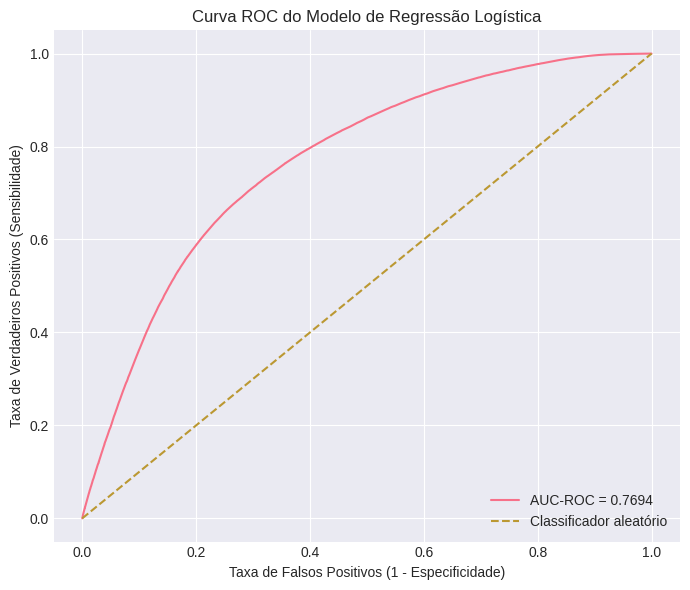

In [8]:
def preparar_dados(df):
    # Cria cópia para evitar alterar o DataFrame original
    df = df.copy()

    # Mantém apenas registros com evolução conhecida (cura ou óbito)
    df = df[df["EVOLUCAO"].isin(["1", "2"])]

    # Variável alvo: 0 = cura, 1 = óbito
    df["OBITO"] = df["EVOLUCAO"].map({"1": 0, "2": 1})

    # Converte idade para formato numérico
    df["NU_IDADE_N"] = pd.to_numeric(df["NU_IDADE_N"], errors="coerce")

    # Mapeia UF para grandes regiões do Brasil
    mapa_regiao = {
        "AC": "Norte", "AP": "Norte", "AM": "Norte", "PA": "Norte",
        "RO": "Norte", "RR": "Norte", "TO": "Norte",
        "AL": "Nordeste", "BA": "Nordeste", "CE": "Nordeste",
        "MA": "Nordeste", "PB": "Nordeste", "PE": "Nordeste",
        "PI": "Nordeste", "RN": "Nordeste", "SE": "Nordeste",
        "DF": "Centro-Oeste", "GO": "Centro-Oeste",
        "MT": "Centro-Oeste", "MS": "Centro-Oeste",
        "ES": "Sudeste", "MG": "Sudeste", "RJ": "Sudeste", "SP": "Sudeste",
        "PR": "Sul", "RS": "Sul", "SC": "Sul"
    }

    df["REGIAO"] = df["SG_UF"].map(mapa_regiao)

    # Seleciona variáveis clínicas, demográficas e alvo
    variaveis = [
        "NU_IDADE_N", "HOSPITAL", "UTI",
        "DIABETES", "CARDIOPATI", "OBESIDADE",
        "PNEUMOPATI", "NEUROLOGIC", "RENAL",
        "IMUNODEPRE", "REGIAO", "OBITO"
    ]

    df = df[variaveis]

    # Converte variáveis binárias para formato numérico
    mapa_binario = {"1": 1, "2": 0}
    for col in df.columns:
        if col not in ["NU_IDADE_N", "REGIAO", "OBITO"]:
            df[col] = df[col].replace("9", np.nan).map(mapa_binario)

    # Remove registros com valores ausentes
    return df.dropna()


def calcular_auc_roc(df):
    # Separa variáveis explicativas e variável alvo
    X = df.drop(columns="OBITO")
    y = df["OBITO"]

    # Divide os dados preservando a proporção da classe alvo
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # Define tipos de variáveis para pré-processamento
    numericas = ["NU_IDADE_N"]
    categoricas = ["REGIAO"]
    binarias = [c for c in X.columns if c not in numericas + categoricas]

    # Padroniza numéricas, codifica categóricas e mantém binárias
    preprocessador = ColumnTransformer([
        ("num", StandardScaler(), numericas),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categoricas),
        ("bin", "passthrough", binarias)
    ])

    # Pipeline com pré-processamento e regressão logística
    pipeline = Pipeline([
        ("prep", preprocessador),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="liblinear",
            random_state=42
        ))
    ])

    # Treina o modelo
    pipeline.fit(X_train, y_train)

    # Probabilidade predita da classe positiva (óbito)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # AUC-ROC no conjunto de teste
    auc_teste = roc_auc_score(y_test, y_prob)

    # Validação cruzada para avaliar estabilidade do modelo
    cv_auc = cross_val_score(
        pipeline, X_train, y_train,
        cv=5, scoring="roc_auc", n_jobs=-1
    )

    return {
        "auc_teste": auc_teste,
        "auc_cv_media": cv_auc.mean(),
        "auc_cv_std": cv_auc.std()
    }


def executar_analise_auc(df):
    # Prepara os dados para modelagem
    df_modelo = preparar_dados(df)

    if df_modelo.empty:
        raise ValueError("Dataset vazio após a preparação.")

    # Executa a modelagem e avaliação AUC-ROC
    resultados = calcular_auc_roc(df_modelo)

    # Exibe resultados finais
    print("RESULTADOS AUC-ROC")
    print(f"AUC teste: {resultados['auc_teste']:.4f}")
    print(
        f"AUC validação cruzada: "
        f"{resultados['auc_cv_media']:.4f} ± {resultados['auc_cv_std']:.4f}"
    )

    return resultados


from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


def plotar_curva_roc(df):
    # Prepara os dados
    df_modelo = preparar_dados(df)

    if df_modelo.empty:
        raise ValueError("Dataset vazio após a preparação.")

    # Separa variáveis explicativas e alvo
    X = df_modelo.drop(columns="OBITO")
    y = df_modelo["OBITO"]

    # Divide em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # Define tipos de variáveis
    numericas = ["NU_IDADE_N"]
    categoricas = ["REGIAO"]
    binarias = [c for c in X.columns if c not in numericas + categoricas]

    # Pré-processamento
    preprocessador = ColumnTransformer([
        ("num", StandardScaler(), numericas),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categoricas),
        ("bin", "passthrough", binarias)
    ])

    # Pipeline com regressão logística
    pipeline = Pipeline([
        ("prep", preprocessador),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="liblinear",
            random_state=42
        ))
    ])

    # Treina o modelo
    pipeline.fit(X_train, y_train)

    # Probabilidades preditas para a classe positiva (óbito)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    # Plota a curva ROC
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"AUC-ROC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Classificador aleatório")
    plt.xlabel("Taxa de Falsos Positivos (1 - Especificidade)")
    plt.ylabel("Taxa de Verdadeiros Positivos (Sensibilidade)")
    plt.title("Curva ROC do Modelo de Regressão Logística")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Execução principal
if __name__ == "__main__":
    resultados = executar_analise_auc(df_limpo)
    plotar_curva_roc(df_limpo)
